In [2]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
import graphviz
from datetime import timedelta
import io
import pandas as pd


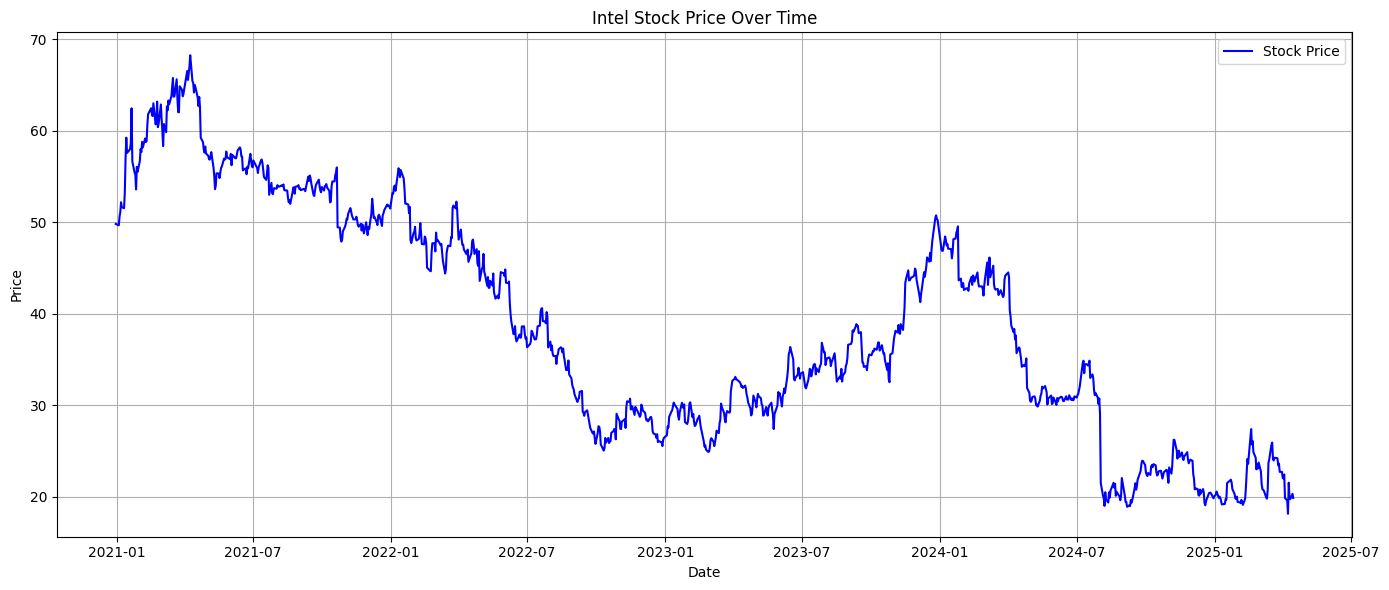

In [17]:
# Step 1: Load and Preprocess Data
# Load the dataset
df = pd.read_csv('C:/Users/Hp/IS403.P23_Nhom3/Dataset/intel_stock_price.csv')

# Clean and format columns
df.columns = ['date', 'price', 'open', 'high', 'low', 'volume', 'change_percent']
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# Clean volume: remove 'M' and convert to float
df['volume'] = df['volume'].replace({'M': 'e6'}, regex=True).astype(float)

# Clean change_percent: remove '%' and convert to float
df['change_percent'] = df['change_percent'].str.replace('%', '').astype(float)

# Sort by date in ascending order
df = df.sort_values('date')

# Visualize raw stock price data
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['price'], label='Stock Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Intel Stock Price Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Step 2: Feature Engineering
# Create features using a lookback window of 5 days
lookback = 5
X = []
y = []

for i in range(lookback, len(df)):
    X.append(df['price'].iloc[i-lookback:i].values)
    y.append(df['price'].iloc[i])

X = np.array(X)
y = np.array(y)

In [7]:
# Step 3: Chia dữ liệu thành train, test, validation
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)  # 80% train+val, 20% test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, shuffle=False, test_size=0.125)  # 70% train, 10% val, 20% test

In [8]:
# Step 4: Scale dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [9]:
# Step 5: Huấn luyện mô hình
model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500,
                          random_state=42)

In [26]:
# Step 6: Dự đoán
y_pred_test = model.predict(X_test_scaled)
y_pred_val = model.predict(X_val_scaled)

# Start with the last 5 days
last_known = df['price'].iloc[-lookback:].values

# Reset future_preds_30 before the 30-day prediction loop
future_preds_30 = [] 

# Predict 30 days
current_input = last_known.copy()
for _ in range(30):
    input_scaled = scaler.transform([current_input])
    next_price = model.predict(input_scaled)[0]
    future_preds_30.append(next_price)
    current_input = np.append(current_input[1:], next_price)

# Reset future_preds_60 before the 60-day prediction loop
future_preds_60 = []

# Predict 60 days
current_input = last_known.copy()
for _ in range(60):
    input_scaled = scaler.transform([current_input])
    next_price = model.predict(input_scaled)[0]
    future_preds_60.append(next_price)
    current_input = np.append(current_input[1:], next_price)

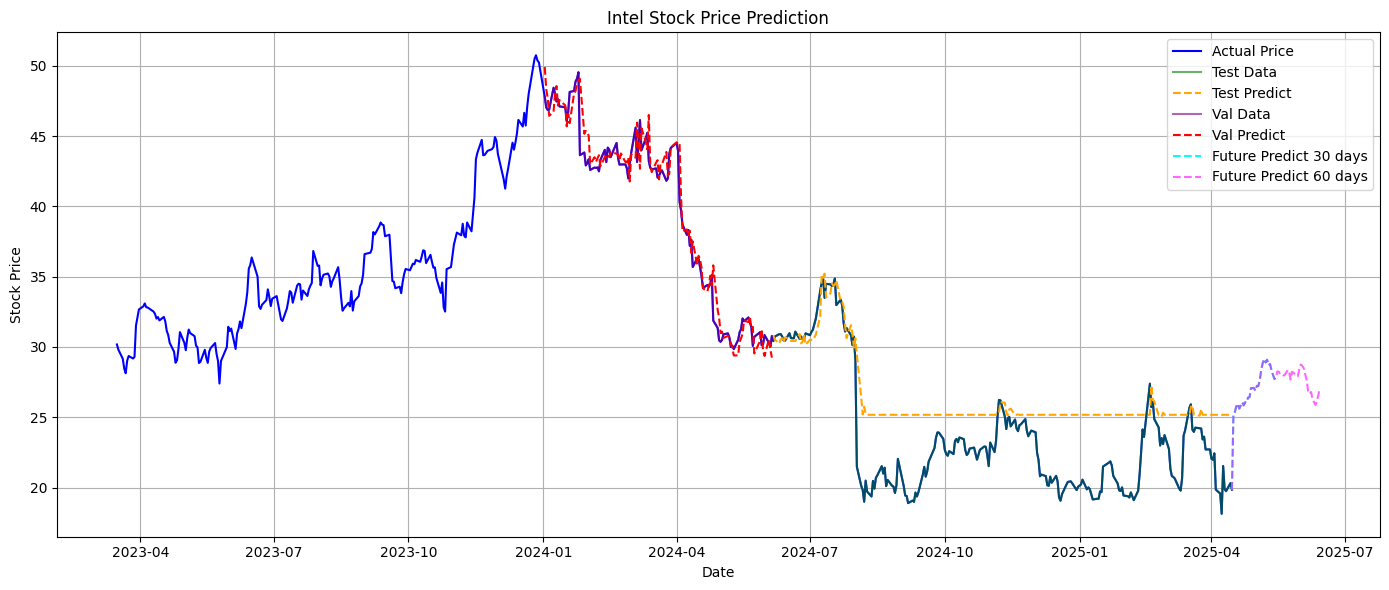

In [27]:
# Step 7: Visualize kết quả
last_date = df['date'].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 61)]

future_preds_30_plot = [df['price'].iloc[-1]] + future_preds_30
future_dates_30_plot = [df['date'].iloc[-1]] + future_dates[:30]

future_preds_60_plot = [df['price'].iloc[-1]] + future_preds_60
future_dates_60_plot = [df['date'].iloc[-1]] + future_dates
plt.figure(figsize=(14, 6))

# Actual Price
plt.plot(df['date'].iloc[-len(y_test) - len(y_val) - 200:], df['price'].iloc[-len(y_test) - len(y_val) - 200:], label='Actual Price', color='blue')

# Test Data & Test Predict
plt.plot(df['date'].iloc[-len(y_test):], y_test, label='Test Data', color='green', alpha=0.6)
plt.plot(df['date'].iloc[-len(y_test):], y_pred_test, label='Test Predict', linestyle='--', color='orange')

# Val Data & Val Predict
plt.plot(df['date'].iloc[-len(y_test) - len(y_val):-len(y_test)], y_val, label='Val Data', color='purple', alpha=0.6)
plt.plot(df['date'].iloc[-len(y_test) - len(y_val):-len(y_test)], y_pred_val, label='Val Predict', linestyle='--', color='red')

# Future Predict 30 days & 60 days
plt.plot(future_dates_30_plot, future_preds_30_plot, label='Future Predict 30 days', linestyle='--', color='cyan')
plt.plot(future_dates_60_plot, future_preds_60_plot, label='Future Predict 60 days', linestyle='--', color='magenta', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Intel Stock Price Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()